In [3]:
import numpy as np
import scipy.stats
import msprime
import pandas as pd
import allel
import multiprocessing
#import pyarrow # required for pandas Data.Frame.to_arrow()

# Functions

### Demographic simulations

In [4]:
def sim_one_population(diploid_size, seq_len, rec_rate, mut_rate):
    '''simulate two populations that have diverged
        from a common ancestral population.
    Returns a tree sequence.

    @diploid_size = the population size of each population,
        also the size of the ancestral population
    @seq_len = length of the genome, units ~ base-pairs
    @rec_rate = recombination rate, units = rate per bp, per generation
    @mut_rate = mutation rate, units = rate per bp, per generation
    '''

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=diploid_size)

    ts = msprime.sim_ancestry(
        samples={'A': diploid_size},  # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate,
        model='dtwf',
    )

    ts = msprime.sim_mutations(
        ts,
        rate=mut_rate,
        discrete_genome=False,
        )

    return ts

In [ ]:
def sample_individuals(haploid_indexes, n, replace):
    """
    return the (haploid) indexes that correspond to
    taking n diploid samples from the supplied haploid indexes

    @haploid_indexes = contiguous indexes for haploids
        should be from a single population.
    @n = the number of diploid indiviudals to take.
    """

    # ensure the haploid indexes are consecutive
    diff = np.diff(haploid_indexes)
    assert np.sum(diff == 1) == (len(haploid_indexes)-1)

    ind_indexes = haploid_indexes[::2]
    ind_samples = np.sort(np.random.choice(ind_indexes, n, replace=replace))
    haploid_samples = np.zeros(len(ind_samples)*2, dtype='int')
    haploid_samples[0::2] = ind_samples
    haploid_samples[1::2] = ind_samples+1
    return(haploid_samples)

In [ ]:
def observe(ts, num_inds, max_sites):
    '''
    oberserve num_inds diploids from each population
    simplify the ts, removing non-variable sites across those individuals

    @ts = tree-sequence
    @num_inds = number of diploids to sample from each population
    @max_sites = retain at most max_sites, from among variable sites
    '''

    popA = ts.samples(population=0)
    popA_inds = sample_individuals(popA, num_inds, replace=False)
    all_inds = popA_inds
    obs_ts = ts.simplify(samples=all_inds)

    if obs_ts.num_sites > max_sites:
        all_sites = np.arange(len(obs_ts.sites()))
        sites_keep = np.random.choice(all_sites, max_sites, replace=False)
        sites_remove = np.setdiff1d(all_sites, sites_keep)
        obs_ts = obs_ts.delete_sites(sites_remove)
    return(obs_ts)

# Example simulation and observation

In [ ]:
# simulation of the entire demographic history
pop_ts = sim_one_population(
    diploid_size=200,
    seq_len=1e9,
    rec_rate=1e-8,
    mut_rate=1e-8
)

In [ ]:
pop_ts

 sim_population() generates one population with a constant population size.  
 
 Here we have specified:
 
 `diploid_size = 200` so each population is composed of 200 diploid individuals.
 
 `seq_len = 1e9` so the genome is ~ a billion basepairs (bp) long.
 
 `rec_rate = 1e-8` so the recombination rate is .00000001 per bp per generation.
 
 `mut_rate = 1e-8` so the mutation rate is .00000001 per bp per generation (same as the mut_rate).

## Data structure
The genetic data is store as a tree sequence [link to documentation](https://tskit.dev/tskit/docs/stable/data-model.html)

In [ ]:
# for a tree-sequence, "samples" are always haploid,
# while we will generally be addressing diploid individuals
pop_ts.num_samples

This ts has 400 "samples". This is due to having one population with 200 diploids. 

`200 (diploids) * 2 (samples per diploid)`

### The `ts` above contains the full history of all indiviudals. 

In practice, researchers rarely get to observe all individuals or variable sites.  

#### We can also simulate a situation where we only get to observe a subset of the individuals/sites.

In [167]:
# The observe() function returns another ts that contains
#     a subset of the individuals and/or sites.
obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=5000)

 Here we have specified:
 
 `ts = pop_ts` so the pop_ts is the initial 2-population ts, with 200 individuals per pop.
 
 `num_inds = 50` so there will be 50 inds individuals per pop in the returned ts.
 
 `max_sites = 5000` so their will be at most 5000 variable sites in the returned ts.

In [168]:
# 50 individuals * 2 (pops) * 2 (samples per diploid)
obs_ts.num_samples, pop_ts.num_samples

(100, 400)

In [170]:
# the number of sites has also be reduced
obs_ts.num_sites,  pop_ts.num_sites

(5000, 52903)

# Summary statistics

Diversity, also often called pi, is a measure the average number of nucleotide differences between genotypes drawn from the same population. 

$ \pi_{within} $  = the average number of pairwise differences between two samples from the same population.

Often, this definition also includes non-variable sites, but we will ignore this and focus just on the variable sites. In this context this is also called the expected heterozygosity.

In [190]:
def site_diversity(ac, n):
    """
    returns the diversity at one or more sites
    
    @ac = count of one of the alleles 
    @n = numer of samples
    """
       
    npairs = int(n*(n-1)/2)  # total numbers of pairs of samples
    n_different_pairs = ac * (n-ac) # number of those pairs that have different alleles
    return (n_different_pairs/npairs)

In [180]:
100*(100-1)/2

4950.0

In [181]:
obs_ts.num_samples

100

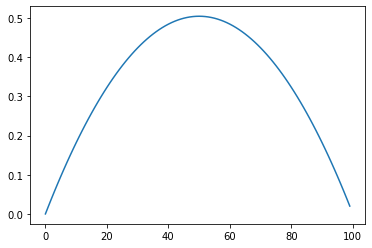

In [220]:
# diversity vs allele count out of 100
r = []
for x in np.arange(100):
    r.append(site_diversity(x, 100))
plt.plot(r)

In [191]:
# diversity at each site
site_diversity(obs_ts.genotype_matrix().sum(1), obs_ts.num_samples)

array([0.25757576, 0.13151515, 0.22848485, ..., 0.07757576, 0.18181818,
       0.02      ])

<AxesSubplot:ylabel='Count'>

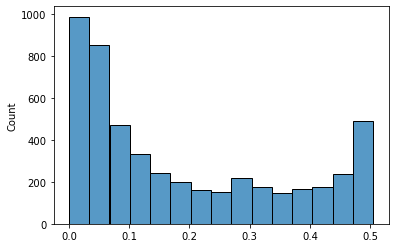

In [192]:
sns.histplot(site_diversity(obs_ts.genotype_matrix().sum(1), obs_ts.num_samples))

In [195]:
# you can also get this with the tskit API, but this wont allow repeated sites or samples
obs_ts.diversity(span_normalise = False, windows = 'sites')

array([0.25757576, 0.13151515, 0.22848485, ..., 0.07757576, 0.18181818,
       0.02      ])

In [197]:
def get_diversity_general(ts, samples, sites_index):
    """returns average pairwise diversity of a set of samples across a set of sites. 

    This function is general in the sense that (samples) and (sites_index)may have duplicates.

    @ts = tree sequence
    @samples = the samples from the first population to be used
    @sites_index = the indexes of the sites to be used.
    """
    nsamples = len(samples)
    genos = obs_ts.genotype_matrix()
    diver = site_diversity(genos[sites_index, :][:,samples].sum(1), nsamples).mean()
    return diver

In [218]:
# applied to the entire observed set
get_diversity_general(
    ts=obs_ts,
    samples=np.arange(obs_ts.num_samples),
    sites_index=np.arange(obs_ts.num_sites),
    )

0.1897050909090909

In [200]:
# mean diversity across sites
site_diversity(obs_ts.genotype_matrix().sum(1), obs_ts.num_samples).mean()

0.1897050909090909

In [204]:
# bootstrap over sites 
get_diversity_general(
    ts=obs_ts,
    samples=np.arange(obs_ts.num_samples),
    sites_index=np.random.choice(obs_ts.num_sites, obs_ts.num_sites, replace = True),
    )

0.19133620202020202

In [207]:
# bootstrap over samples 
get_diversity_general(
    ts=obs_ts,
    samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
    sites_index=np.arange(obs_ts.num_sites),
    )

0.18838840404040405

Text(0.5, 1.0, '5000 bootstraps over sites')

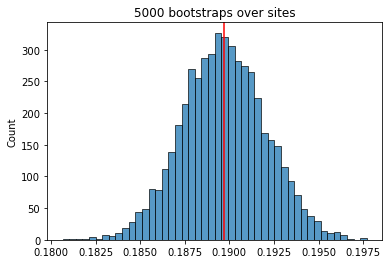

In [206]:
res = []
for i in range(5000):
    res.append(get_diversity_general(
        ts=obs_ts,
        samples=np.arange(obs_ts.num_samples),
        sites_index=np.random.choice(obs_ts.num_sites, obs_ts.num_sites, replace = True),
        )
    )

sns.histplot(res)
plt.axvline(site_diversity(obs_ts.genotype_matrix().sum(1), obs_ts.num_samples).mean(), color = 'red')
plt.title('5000 bootstraps over sites')

Text(0.5, 1.0, '5000 bootstraps over samples')

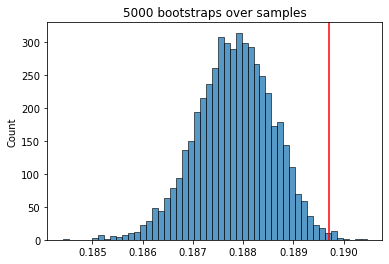

In [210]:
res = []
for i in range(5000):
    res.append(get_diversity_general(
        ts=obs_ts,
    samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
    sites_index=np.arange(obs_ts.num_sites),
        )
    )

sns.histplot(res)
plt.axvline(site_diversity(obs_ts.genotype_matrix().sum(1), obs_ts.num_samples).mean(), color = 'red')
plt.title('5000 bootstraps over samples')

In [ ]:
for sim in nsims: # 10
    true_val = diversity(sim) 
    for obs in observations: # numbers of sites and inds
        obs_vals = diversity(obs) 
        bt_ci = do_bootstrap() 
        jk_ci = do_jackknife()
        coverage = get_coverage(bt_ci, jk_ci)

# jackknife can be doen with np.delete

In [211]:
np.delete

In [213]:
ar = np.arange(4, 15)
ar

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [217]:
# removes the value at index 6
np.delete(ar, 6)

array([ 4,  5,  6,  7,  8,  9, 11, 12, 13, 14])

In [215]:
np.delete(ar, 0)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])